In [3]:
import fitz  
import os
import re
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import time
import requests
import umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

In [4]:
import pandas as pd
import os
import requests
import time

CSV_PATH = r"C:\Users\joeva\Downloads\ai_gov\data_collection\data\ai_governance_categorized_01.csv"             
DOWNLOAD_DIR = r"C:\Users\joeva\Downloads\ai_gov\data\raw"           
BATCH_SIZE = 30                         
TIMEOUT = 30                           

os.makedirs(DOWNLOAD_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

if "Status" not in df.columns:
    df["Status"] = "pending"
if "Local Filename" not in df.columns:
    df["Local Filename"] = ""

pending_df = df[df["Status"] == "pending"].head(BATCH_SIZE)

print(f"Starting batch download of {len(pending_df)} PDFs...")

for idx, row in pending_df.iterrows():
    url = row["PDF Link"]
    local_filename = os.path.join(DOWNLOAD_DIR, f"doc_{idx}.pdf")
    
    try:
        response = requests.get(url, timeout=TIMEOUT)
        response.raise_for_status()
        
        with open(local_filename, "wb") as f:
            f.write(response.content)

        df.at[idx, "status"] = "done"
        df.at[idx, "local filename"] = local_filename
        print(f"downloaded: {url}")

    except Exception as e:
        df.at[idx, "Status"] = "error"
        print(f"failed to download {url} — {e}")

    time.sleep(1) 

df.to_csv(CSV_PATH, index=False)

Starting batch download of 30 PDFs...
downloaded: https://www.hhs.texas.gov/sites/default/files/documents/eqro-annual-tech-report-contract-yr-2022.pdf
downloaded: https://portal.ct.gov/-/media/OPM/Fin-General/Policies/CT-Responsible-AI-Policy-Framework-Final-02012024.pdf
downloaded: https://portal.ct.gov/-/media/opm/fin-cfo/the-state-of-connecticut-information-and-telecommunications-strategic-plan-fy25---part-i.pdf
downloaded: https://idoi.illinois.gov/content/dam/soi/en/web/insurance/companies/companybulletins/CB2024-08.pdf
downloaded: https://doit.illinois.gov/content/dam/soi/en/web/doit/meetings/ai-taskforce/reports/2024-gen-ai-task-force-report.pdf
downloaded: https://doit.illinois.gov/content/dam/soi/en/web/doit/meetings/ai-taskforce/reports/20241220-gen-ai-task-force-report.pdf
downloaded: https://gac.illinois.gov/content/dam/soi/en/web/gac/las/documents/Mental%20Health%20Video%20Trials.pdf
downloaded: https://dph.illinois.gov/content/dam/soi/en/web/idph/publications/about-idph/I

In [6]:
def extract_text_from_pdf(path):
    doc = fitz.open(path)
    return " ".join([page.get_text() for page in doc])

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def process_pdfs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for fname in os.listdir(input_dir):
        if fname.endswith(".pdf"):
            pdf_path = os.path.join(input_dir, fname)
            try:
                raw_text = extract_text_from_pdf(pdf_path)
                cleaned = clean_text(raw_text)
                out_path = os.path.join(output_dir, fname.replace(".pdf", ".txt"))
                with open(out_path, "w", encoding="utf-8", errors="replace") as f:
                    f.write(cleaned)
            except Exception as e:
                print(f"Failed to process {fname}: {e}")

if __name__ == "__main__":
    process_pdfs(r"C:\Users\joeva\Downloads\ai_gov\data\raw", r"C:\Users\joeva\Downloads\ai_gov\data\processed")

KeyboardInterrupt: 

In [ ]:
def get_top_terms_per_cluster(docs, labels, num_terms=10):
    df = pd.DataFrame({"doc": docs, "cluster": labels})
    cluster_terms = {}
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    for cluster_id in set(labels):
        if cluster_id == -1:  
            continue
        cluster_docs = df[df["cluster"] == cluster_id]["doc"].tolist()
        X = vectorizer.fit_transform(cluster_docs)
        terms = vectorizer.get_feature_names_out()
        top_indices = X.sum(axis=0).A1.argsort()[::-1][:num_terms]
        top_words = [terms[i] for i in top_indices]
        cluster_terms[cluster_id] = top_words
    return cluster_terms

In [108]:
nltk.download('stopwords')
nltk.download('wordnet')

# Custom stopwords
custom_stopwords = set(stopwords.words('english') + ["ai", "use", "data", "state", "including", "systems", "artificial", "intelligence", "genai", "digital", "gai"])
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = text.lower().split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in custom_stopwords and w.isalpha()]
    return " ".join(words)

def load_documents_from_folder(folder_path):
    docs, filenames = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".txt"):
            full_path = os.path.join(folder_path, filename)
            with open(full_path, "r", encoding="utf-8", errors="replace") as f:
                text = f.read().strip()
                if text:
                    docs.append(preprocess(text))
                    filenames.append(filename)
    return docs, filenames
    
def show_sample_documents(docs, filenames, labels):
    df = pd.DataFrame({"Filename": filenames, "Text": docs, "Cluster": labels})
    for cluster_id in sorted(df["Cluster"].unique()):
        if cluster_id == -1:
            continue
        print(f"\nCluster {cluster_id} sample documents:")
        sample = df[df["Cluster"] == cluster_id].sample(n=min(3, len(df[df["Cluster"] == cluster_id])), random_state=42)
        for _, row in sample.iterrows():
            print(f"- {row['Filename']} | {row['Text'][:200]}...")

def compute_cluster_similarities(embeddings, labels):
    df = pd.DataFrame({"label": labels})
    cluster_means = {}
    for label in df["label"].unique():
        if label == -1:
            continue
        cluster_means[label] = np.mean(embeddings[labels == label], axis=0)
    keys = sorted(cluster_means.keys())
    matrix = cosine_similarity([cluster_means[k] for k in keys])
    sim_df = pd.DataFrame(matrix, index=keys, columns=keys)
    print("\nInter-cluster cosine similarity matrix:")
    print(sim_df.round(2))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joeva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joeva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

c:\Users\joeva\anaconda3\envs\ai_nlp\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\joeva\anaconda3\envs\ai_nlp\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\joeva\anaconda3\envs\ai_nlp\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\joeva\anaconda3\envs\ai_nlp\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster 0: program, student, cosc, science, course, university, computer, research, learning, education
Cluster 1: risk, standard, nist, information, technology, management, development, rmf, organization, actor
Cluster 2: emission, air, vehicle, control, commission, rule, texas, quality, environmental, requirement
Cluster 3: bias, model, attack, privacy, term, used, nist, learning, security, poisoning
Cluster 4: learning, model, machine, et, adversarial, technology, privacy, distribution, training, feature
Cluster 5: risk, model, california, policy, government, information, benefit, public, tool, training
Cluster 6: risk, agency, security, information, privacy, washington, cybersecurity, impact, university, process
Cluster 7: cancer, health, national, clinical, patient, integrated, research, et, panel, care
Cluster 8: illinois, generative, worker, technology, task, public, risk, policy, school, employer
Cluster 9: health, indian, tribal, service, care, program, community, american, tr

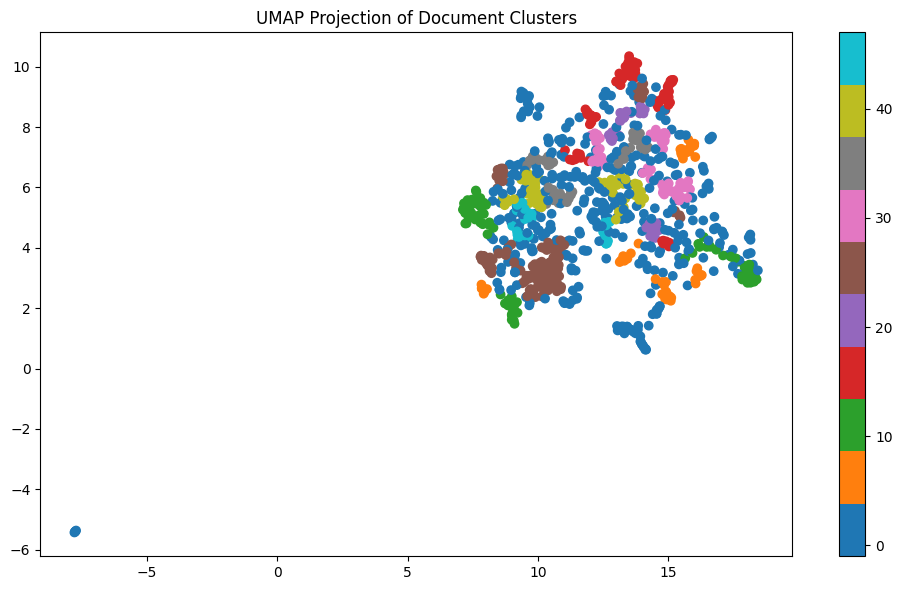

In [109]:
if __name__ == "__main__":
    folder = r"C:\Users\joeva\Downloads\ai_gov\data\processed"
    docs, filenames = load_documents_from_folder(folder)

    if not docs:
        print(f"No documents found in {folder}")
        exit(1)

    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(docs, show_progress_bar=True)

    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='cosine', random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', prediction_data=True)
    cluster_labels = clusterer.fit_predict(reduced_embeddings)

    cluster_terms = get_top_terms_per_cluster(docs, cluster_labels)
    for cid, words in cluster_terms.items():
        print(f"Cluster {cid}: {', '.join(words)}")

    show_sample_documents(docs, filenames, cluster_labels)

    compute_cluster_similarities(embeddings, cluster_labels)

    df = pd.DataFrame({
        "Filename": filenames,
        "Cluster": cluster_labels
    })
    df.to_csv("huggingface_cluster_assignments.csv", index=False)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title("UMAP Projection of Document Clusters")
    plt.tight_layout()
    plt.savefig("huggingface_umap_plot.png")
    plt.show()